In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

In [2]:
data = np.load(r'F:\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz', allow_pickle=True)

In [3]:
data['meta']

array([['time', '28/10/2025 11:07:19'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [4]:
# Diffusivity estimation m^2/s
a=2/(700*1600)
a

1.7857142857142857e-06

In [5]:
data['data'].shape

(334, 512, 512)

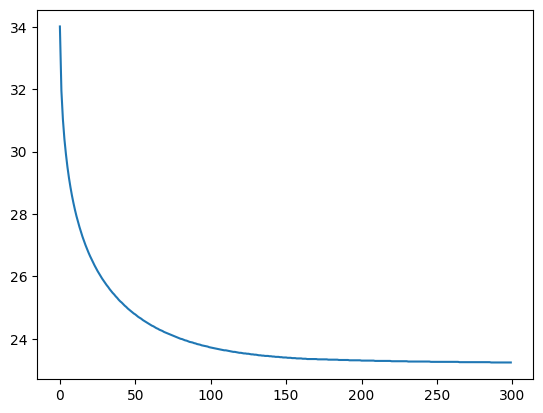

In [6]:
plt.plot(data['data'][34:,256,256])

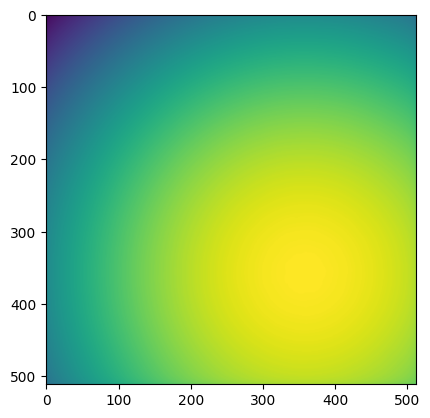

In [7]:
plt.imshow(data['data'][34,:,:])

In [ ]:
data_cube = torch.tensor(data['data'][34:,:,:], dtype=torch.float32)
data_cube=(data_cube-data_cube.min())/(data_cube.max()-data_cube.min()) # Normalization of the temperature data
# Initial condition at t=0
Y_ic = data_cube[0, :, :]          # shape [Y, X]
X_y, X_x = torch.meshgrid(torch.linspace(0,1,512), torch.linspace(0,1,512), indexing='ij')
X_ic = torch.cat([
    torch.zeros(262144,1),           # t=0
    X_y.reshape(-1,1),
    X_x.reshape(-1,1)
], dim=1)
Y_ic = Y_ic.reshape(-1,1)

In [40]:
data_cube = torch.tensor(data['data'], dtype=torch.float32)  # shape [T, Y, X]
T, Y, X = data_cube.shape

time = torch.linspace(0, 1, T)
y_space = torch.linspace(0, 1, Y)
x_space = torch.linspace(0, 1, X)


X_bc_left = torch.stack([
    time.repeat_interleave(Y),          # repeat each t for all y
    y_space.repeat(T),                  # each y repeated across t
    torch.zeros(T*Y)                    # x=0
], dim=1)

Y_bc_left = data_cube[:, :, 0].reshape(-1,1)  # flatten [T*Y,1]

X_bc_right = torch.stack([
    time.repeat_interleave(Y),
    y_space.repeat(T),
    torch.ones(T*Y)                      # x=1
], dim=1)

Y_bc_right = data_cube[:, :, -1].reshape(-1,1)

X_bc_bottom = torch.stack([
    time.repeat_interleave(X),
    torch.zeros(T*X),                   # y=0
    x_space.repeat(T)
], dim=1)

Y_bc_bottom = data_cube[:, 0, :].reshape(-1,1)


X_bc_top = torch.stack([
    time.repeat_interleave(X),
    torch.ones(T*X),                    # y=1
    x_space.repeat(T)
], dim=1)

Y_bc_top = data_cube[:, -1, :].reshape(-1,1)

X_bc = torch.cat([X_bc_left, X_bc_right, X_bc_bottom, X_bc_top], dim=0)
Y_bc = torch.cat([Y_bc_left, Y_bc_right, Y_bc_bottom, Y_bc_top], dim=0)

In [53]:
N_total = X_bc.shape[0]
N_sample = 512  # how many points you want

# Random indices
indices = torch.randperm(N_total)[:N_sample]

# Sample points
X_bc_sampled = X_bc[indices]
Y_bc_sampled = Y_bc[indices]

In [54]:
X_bc_sampled

tensor([[0.2132, 0.7554, 0.0000],
        [0.2973, 1.0000, 0.5323],
        [0.9369, 1.0000, 0.5597],
        ...,
        [0.1772, 0.5675, 0.0000],
        [0.7928, 0.0000, 0.8493],
        [0.7417, 0.5225, 1.0000]])

In [45]:
N_total_ic = X_ic.shape[0]
N_sample_ic = 128

indices_ic = torch.randperm(N_total_ic)[:N_sample_ic]
X_ic_sampled = X_ic[indices_ic]
Y_ic_sampled = Y_ic[indices_ic]